## Background
The **Wa**ter **P**roductivity through **O**pen access of **R**emotely sensed derived data (WaPOR) monitors and reports on agricultural water productivity through biophysical measures with a focus on Africa and the Near East. This information assists partner countries improve land and water productivity in both rainfed and irrigated agriculture ([Peiser et al. 2017](https://openknowledge.fao.org/items/cdacf817-c13a-4859-b681-a4bdc20c065c)). 

Evapotranspiration is of particular interest in irrigated agricultural lands. It can be informative to visualise how plant growth (photosynthesis/biomass production) progresses through a season alongside evapotranspiration.

## Description
This notebook provides and introduction to WaPOR data and nomenclature, and demonstrates loading and plotting.

1. First, we load the cropland mask to define the area of interest for the visualisation.
2. Then, the seasonal pattern of local cropping is inspected using an Enhanced Vegetation Index (EVI) time series to identify a period for the visualistion.
3. Once the season is defined, evapotranspiration and net primary productivity data are loaded.
4. Finally, EVI, net primary productivity, and evapotranspiration are plotted in a single visualisation.
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Tools` package.

In [1]:
import datacube
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import geopandas as gpd

from datacube.utils.masking import mask_invalid_data
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard
from deafrica_tools.load_wapor import get_all_WaPORv3_mapsets, get_WaPORv3_info, load_wapor_ds
from deafrica_tools.plotting import display_map
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from odc.geo.geom import Geometry
from odc.geo.xr import xr_reproject
from wapordl import wapor_map

INFO: WaPORDL (`1.2.1`)


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="WaPOR")

### Analysis parameters

The cell below specifies the folder where the downloaded data will be stored. If you are using this script repeatedly, it is recommended you empty this folder from time to time to reduce storage on the Sandbox volume. 

In [3]:
folder = "../Supplementary_data/WaPOR" # folder that the data will be sent to

Next, the area of interest is defined. This can also be a `.geojson` file which the loading function accepts. Otherwise, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 30.75`, `lon = 31.35`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (30.75, 31.35).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 30.75`, `lon = 31.35`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(30.75, 31.35)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as an ` Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

As for the [loading WaPOR data notebook](../Datasets/WaPOR.ipynb), this demonstration notebook loads an area of cropland in the Nile Delta, Egypt. The Nile Delta supports irrigated agriculture in a very arid climate. This means it has very low cloud cover and easily distinguishable cropping patterns from satellite imagery, making it a useful testing area for Earth Observation based analyses.

In [4]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=30.75, lon=31.35, buffer=0.03)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

region = [geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[2], geopolygon_gdf.total_bounds[3]]

display_map(x=lon_range, y=lat_range)

## Load Sentinel-2 imagery

We will use surface reflectance data to calculate indices for an initial assessment of crop phenology, so we load Sentinel-2 data for this.

In [5]:
period = ["2022-01-01", "2023-12-31"]

query = {
    "y": (region[1],region[3]),
    "x": (region[0],region[2]),
    "time": period,
    "measurements": ["red", "green", "blue", "nir"],
    "resolution": (-20, 20),
    "output_crs": "epsg:6933", #match wapor
    "group_by": "solar_day",
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=["s2_l2a"],
    **query,
)

ds

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 146 time steps


/opt/venv/lib/python3.12/site-packages/deafrica_tools/datahandling.py:565: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_data, ds_masks])
/opt/venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


<xarray.Dataset> Size: 224MB
Dimensions:      (time: 146, y: 331, x: 290)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2022-01-03T08:41:33 ... 2023-12-29...
  * y            (y) float64 3kB 3.745e+06 3.745e+06 ... 3.738e+06 3.738e+06
  * x            (x) float64 2kB 3.022e+06 3.022e+06 ... 3.028e+06 3.028e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (time, y, x) float32 56MB 494.0 513.0 406.0 ... 532.0 614.0
    green        (time, y, x) float32 56MB 991.0 968.0 835.0 ... 615.0 722.0
    blue         (time, y, x) float32 56MB 653.0 625.0 576.0 ... 358.0 409.0
    nir          (time, y, x) float32 56MB 4.67e+03 5.447e+03 ... 2.059e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Load the cropland mask

In this notebook, we are interested in the phenology of crops. Therefore, we limit our area to cropland only to eliminate the effect of other land cover classes. We use the Digital Earth Africa cropland mask to do this below.

Firstly, we load the cropland mask for the area of interest.

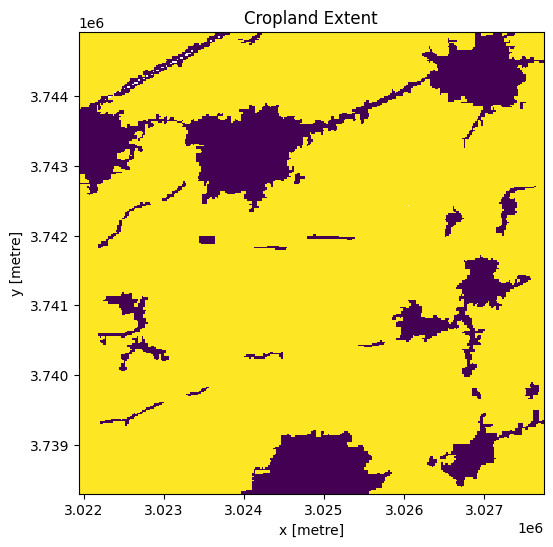

In [6]:
cm = dc.load(
    product="crop_mask",
    time=("2019"),
    measurements="filtered",
    resampling="nearest",
    like=ds.geobox,
).filtered.squeeze()

cm.where(cm < 255).plot.imshow(
    add_colorbar=False, figsize=(6, 6)
)  # we filter to <255 to omit missing data
plt.title("Cropland Extent");

Next, we mask the Sentinel-2 data, `ds`, to cropland areas.

In [7]:
ds = ds.where(cm == 1)

We will use the Enhanced Vegetation Index (EVI) to get an intial picture of phenology. This is a preferred index because it is more sensitive at high levels of greenness, which are observed in densely planted irrigated crops, which we are looking at here. We can therefore better identify progression of the crop season with EVI than with other indices.

In [8]:
ds = calculate_indices(ds, index='EVI', satellite_mission="s2")

The cell below resamples the EVI timeseries to regular 10 day intervals. This means that the EVI time series will match the regularity of the WaPOR dekadal data.

In [9]:
resample_period = "10D"
window = 4

veg_smooth = (
    ds['EVI']
    .resample(time=resample_period)
    .median()
    .rolling(time=window, min_periods=1)
    .mean()
)

## Inspect phenology

Plotting the EVI timeseries over two years (2022 & and 2023) shows that the area we've selected follows a 'double cropping' pattern where two crops are grown within a 12-month period. Based on the EVI profile, the primary season appears to be from approximately November to June, with a secondary season from approximately June to November. This corresponds with [characterisations of cropping systems in the Nile Delta](https://www.scirp.org/journal/paperinformation?paperid=57314#:~:text=In%20the%20Nile%20Delta%2C%20crop,May%20and%20ending%20in%20October.).

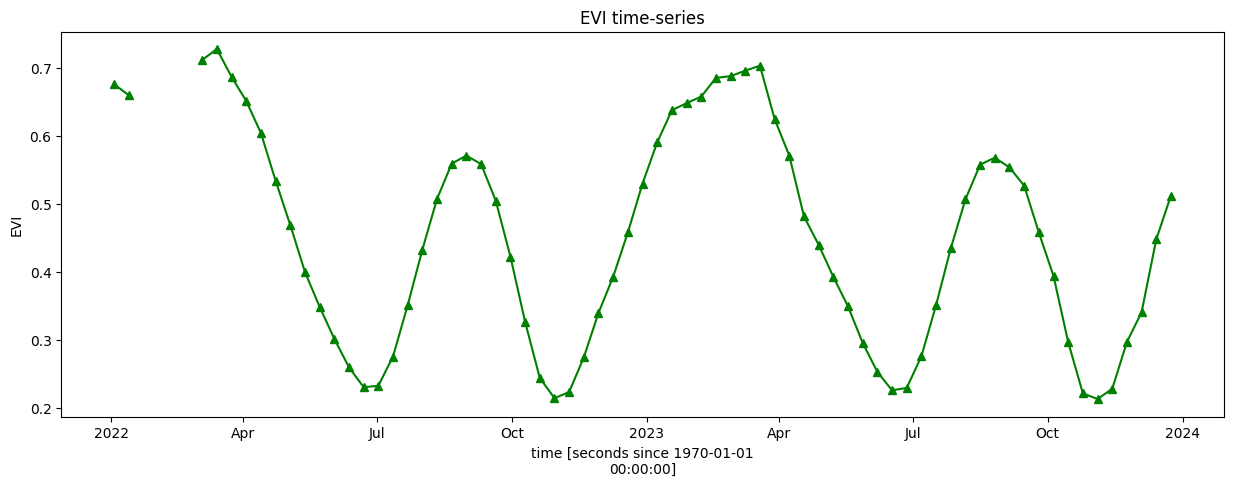

In [10]:
veg_smooth_1D = veg_smooth.mean(["x", "y"])
veg_smooth_1D.plot.line("b-^", figsize=(15, 5), color='green')
_max = veg_smooth_1D.max()
_min = veg_smooth_1D.min()

plt.title("EVI time-series")
plt.ylabel('EVI');

For the remaining visualisations, we will focus on the primary (winter) season between approximately October 2022 and June 2023. We will conduct a more definitive phenology analysis to identify the start and end of season, but first we need to limit our timeseries to a discrete season, as below.

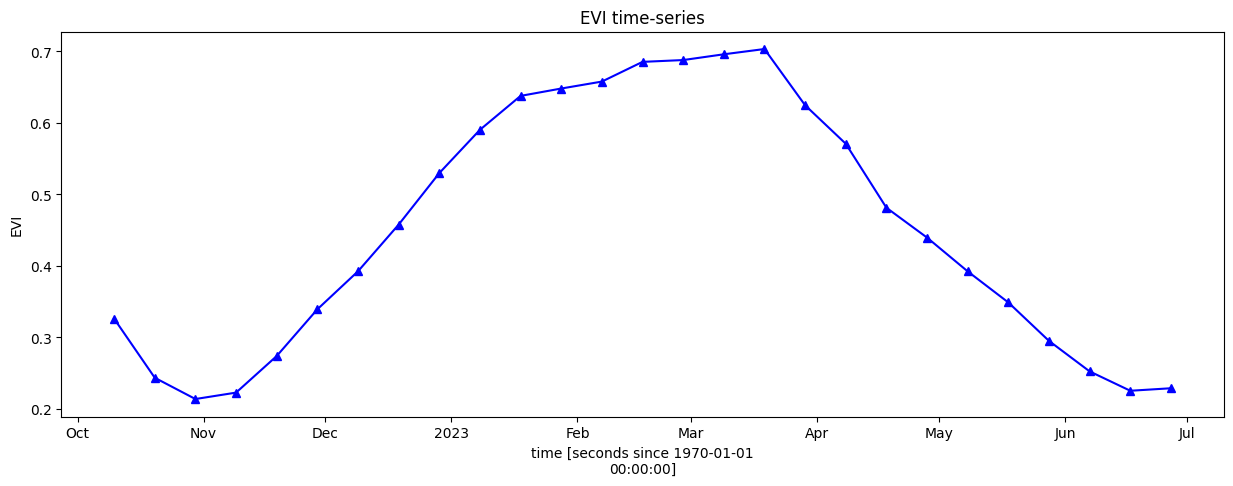

In [11]:
veg_smooth_1D = veg_smooth.mean(["x", "y"]).sel(time=slice('2022-10', '2023-06'))
veg_smooth_1D.plot.line("b-^", figsize=(15, 5))
_max = veg_smooth_1D.max()
_min = veg_smooth_1D.min()

plt.title("EVI time-series")
plt.ylabel('EVI');

## Calculate phenology statistics

The cell below calculates phenological statistics for the selected timeseries, which will enable us to limit our analysis to a defined crop season.

The statistics are:

* SOS - start of season date and its value (vSOS)
* POS - peak of season date and its value (vPOS)
* EOS - end of season date and its value (EOS)
* Trough - minimum value
* LOS - length of season (EOS - SOS)
* AOS - amplitude (vPOS - Trough)
* ROG - rate of greening = (vPOS - vSOS) / (POS - SOS)
* ROS - rate of senescing = (vEOS - vPOS) / (EOS - POS)

We also define the methods for detection of SOS and EOS, as below.

`method_sos :` If ‘first’ then vSOS is estimated as the first positive slope on the greening side of the curve. If ‘median’, then vSOS is estimated as the median value of the postive slopes on the greening side of the curve.

`method_eos :` If ‘last’ then vEOS is estimated as the last negative slope on the senescing side of the curve. If ‘median’, then vEOS is estimated as the ‘median’ value of the negative slopes on the senescing side of the curve.

More information on phenological methods is available in the detailed documentation of [temporal statistics](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/deafrica_tools/temporal.py).

In [12]:
basic_pheno_stats = [
    "SOS",
    "vSOS",
    "POS",
    "vPOS",
    "EOS",
    "vEOS",
    "Trough",
    "LOS",
    "AOS",
    "ROG",
    "ROS",
]
method_sos = "first"
method_eos = "last"

years = veg_smooth_1D.groupby("time.year")

# store results in dict
pheno_results = {}

# loop through years and calculate phenology
for y, year in years:
    # calculate stats
    stats = xr_phenology(
        year,
        method_sos=method_sos,
        method_eos=method_eos,
        stats=basic_pheno_stats,
        verbose=False,
    )
    # add results to dict
    pheno_results[str(y)] = stats

df_dict = {}
for key, value in pheno_results.items():
    df_dict_1 = {}
    for b in value.data_vars:
        if value[b].dtype == np.dtype("<M8[ns]") or value[b].dtype == np.dtype("int16"):
            result = pd.to_datetime(value[b].values)
        else:
            result = round(float(value[b].values), 3)
        df_dict_1[b] = result
    df_dict[key] = df_dict_1

df = (pd.DataFrame(df_dict)).T
df

,SOS,vSOS,POS,vPOS,EOS,vEOS,Trough,LOS,AOS,ROG,ROS
2022,2022-11-09 00:00:00,0.223,2022-12-29 00:00:00,0.53,NaT,NaN,0.214,0.0,0.316,0.006,NaN
2023,2023-01-08 00:00:00,0.59,2023-03-19 00:00:00,0.703,2023-06-17 00:00:00,0.225,0.225,160.0,0.478,0.002,-0.005


### Season plot

Below, the EVI timeseries is plotted with start of season, peak of season, and end of season labelled.

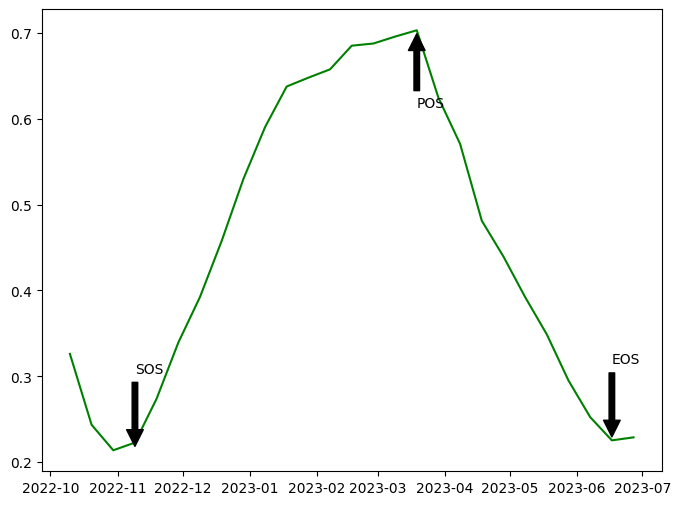

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

y = veg_smooth_1D
x = veg_smooth_1D.time

line, = ax.plot(x,y, color='green')
ax.annotate('SOS', xy=(df.SOS[0], df.Trough[0]), xytext=(df.SOS[0], df.Trough[0]+0.09),
            arrowprops=dict(facecolor='black', shrink=0.05),)
ax.annotate('POS', xy=(df.POS[1], df.vPOS[1]), xytext=(df.POS[1], df.vPOS[1]-0.09),
            arrowprops=dict(facecolor='black', shrink=0.05),)
ax.annotate('EOS', xy=(df.EOS[1], df.vEOS[1]), xytext=(df.EOS[1], df.vEOS[1]+0.09),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()

## Load and plot dekadal evapotranspiration

Now that we have identified the start and end of season, we can load evapotranspiration data. We load this at 10 day (dekadal) intervals below.

Clicking on the attributes element when the dataset is shown reveals units, scale factors, and other useful information. 

Note that scale and offset values have been incorporated into the load_wapor_ds() function so the values returned are in the units shown below, in this case mm/day.

In [14]:
period = [pd.to_datetime(df.SOS)[0], pd.to_datetime(df.EOS)[1]]
variable = 'L3-AETI-D'

aetid = wapor_map(region, variable, period, folder, extension = '.nc')

aetid_xr = load_wapor_ds(filename=aetid, variable=variable)

aetid_xr

INFO: Found 23 files for L3-AETI-D.
INFO: Converting from `.tif` to `.nc`.


<xarray.Dataset> Size: 18MB
Dimensions:      (x: 294, y: 338, time: 23)
Coordinates:
  * x            (x) float64 2kB 3.391e+05 3.392e+05 ... 3.45e+05 3.45e+05
  * y            (y) float64 3kB 3.406e+06 3.406e+06 ... 3.4e+06 3.4e+06
  * time         (time) datetime64[ns] 184B 2022-11-01 2022-11-11 ... 2023-06-11
    spatial_ref  int32 4B 32636
Data variables:
    L3-AETI-D    (time, y, x) float64 18MB -999.9 -999.9 ... -999.9 -999.9
Attributes:
    long_name:            Actual EvapoTranspiration and Interception
    overview:             NONE
    temporal_resolution:  Dekad
    units:                mm/day
    scale_factor:         0.1
    _FillValue:           -9999
    add_offset:           0.0

To limit the evapotranspiration data to cropland areas, we must reproject it.

In [20]:
# Reproject data
aetid_xr_reprojected = aetid_xr.odc.reproject(how=ds.odc.geobox, resampling="average")

#Set nodata to `NaN`
aetid_xr_reprojected = mask_invalid_data(aetid_xr_reprojected)
aetid_xr_crop = aetid_xr_reprojected.where(cm == 1).where(aetid_xr_reprojected['L3-AETI-D'] != -9999)

The plot below shows evapotranspiration in mm/day for the first timestep in the dekadal timeseries. 

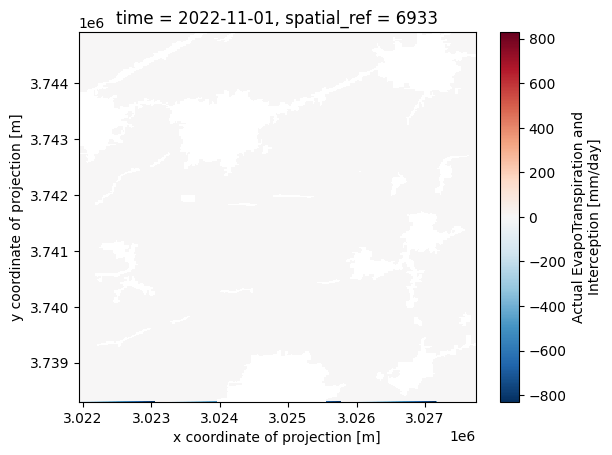

In [21]:
aetid_xr_crop['L3-AETI-D'].isel(time=0).plot()

Finally, the timeseries of evapotranspiration for cropland areas is plotted.

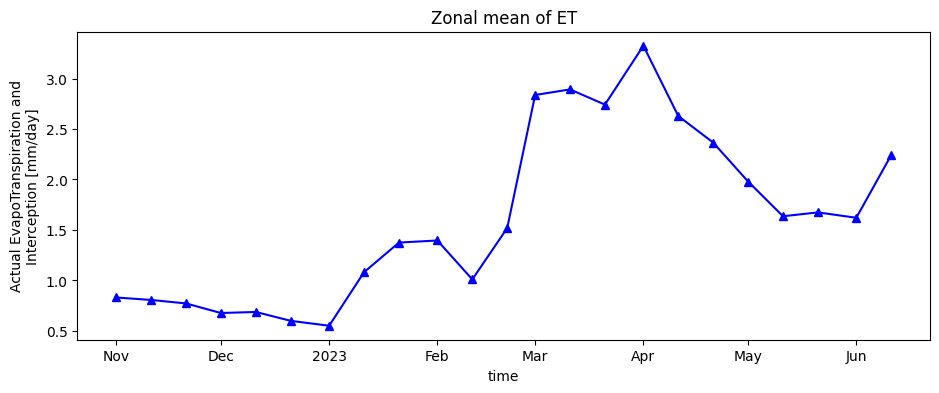

In [22]:
aetid_xr_crop['L3-AETI-D'].mean(["x", "y"]).plot.line("b-^", figsize=(11, 4))
plt.title("Zonal mean of ET");

## Load and plot dekadal Net Primary Productivity

Dekadal biomass production (net primary productivity) is loaded below, then reprojected and crpped to the cropland area as for evapotranspiration.

INFO: Found 23 files for L3-NPP-D.
INFO: Converting from `.tif` to `.nc`.


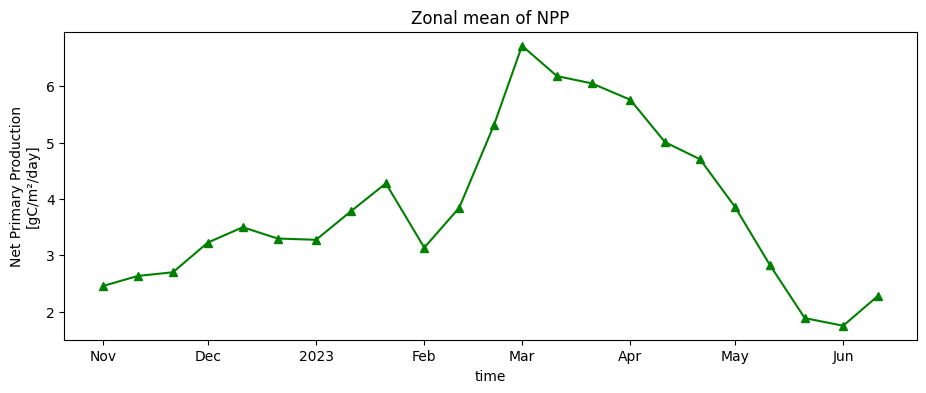

In [23]:
variable = 'L3-NPP-D'

nppd = wapor_map(region, variable, period, folder, extension = '.nc')

nppd_xr = load_wapor_ds(filename=nppd, variable=variable)

# Reproject data
nppd_xr_reprojected = xr_reproject(src=nppd_xr,
                              how=ds.odc.geobox,
                              resampling="average")

#Set nodata to `NaN`
nppd_xr_reprojected = mask_invalid_data(nppd_xr_reprojected)

nppd_xr_crop = nppd_xr_reprojected.where(cm == 1)

nppd_xr_crop['L3-NPP-D'].mean(["x", "y"]).plot.line("g-^", figsize=(11, 4))
plt.title("Zonal mean of NPP");

## Combine variables into one plot

Finally, EVI, ET, and NPP are plotted together to inspect the progression of the crop season. This can be used to draw inferences about the crop season. For example, we can see a dip in NPP & ET following February 2023, associated with a slowing in the rate of EVI growth. This suggests crop growth activity slowed. It's not clear what caused this. It could be a lack of irrigation water, a nutrient issue, or thermal stress. This analysis is therefore exploratory and informs further analyses that could be undertaken.

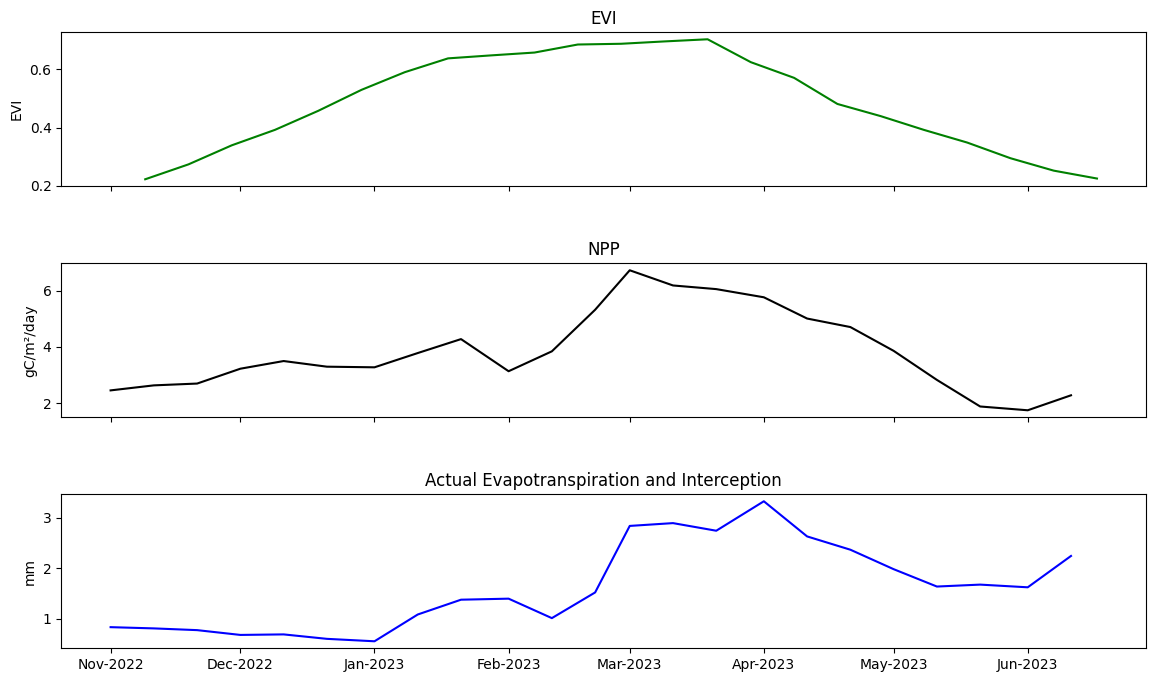

In [24]:
fig, axs = plt.subplots(3, sharex=True, figsize=(14,8), gridspec_kw={'hspace': 0.5})

veg_smooth_1D_slice = veg_smooth_1D.sel(time=slice(*period))

axs[0].set_title('EVI')
axs[0].set_ylabel('EVI')
axs[0].plot(veg_smooth_1D_slice.time, veg_smooth_1D_slice, color='green')

axs[1].set_title('NPP')
axs[1].set_ylabel('gC/m²/day')
axs[1].plot(nppd_xr_crop['L3-NPP-D'].mean(["x", "y"]).time, nppd_xr_crop['L3-NPP-D'].mean(["x", "y"]), color='black')

axs[2].set_title('Actual Evapotranspiration and Interception')
axs[2].set_ylabel('mm')
axs[2].plot(aetid_xr_crop['L3-AETI-D'].mean(["x", "y"]).time, aetid_xr_crop['L3-AETI-D'].mean(["x", "y"]), color='blue')
axs[2].xaxis_date()
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

## Conclusion

This notebook demonstrated using WaPOR through a crop season and integrating it with phenology tools to understand seasonal crop patterns. The seasonal analysis techniques and visualisations shown in this notebook inform further analyses that could be undertaken.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [26]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-11-24'